In [12]:
import cv2

In [13]:
cv2.__version__

'4.7.0'

## Complete end to end training of the ocr model

### Generating synthetic dataset

In [1]:
import zipfile
import datetime
import string
import math
import os 

import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr as koc

In [2]:
data_dir = '.'
alphabet = string.digits + string.ascii_letters + '!?. '
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
fonts = koc.data_generation.get_fonts(
    alphabet=alphabet,
    cache_dir = data_dir
)

backgrounds = koc.data_generation.get_backgrounds(cache_dir = data_dir)

Looking for .\fonts.zip


Filtering fonts.: 100%|████████████████████████████████████████████████████████████| 2746/2746 [00:40<00:00, 68.55it/s]


Looking for .\backgrounds.zip


In [3]:
len(fonts)

2674

With our alphabets, backgrounds and fonts we can build our data generator

In [3]:
text_generator = koc.data_generation.get_text_generator(alphabet=alphabet)
print('The first generated text is: ', next(text_generator))

The first generated text is:  From news Temple in India.    On March 11 2011 Japan suffered the


In [4]:
def get_train_test_split(arr):
    train, valtest =sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

In [6]:
background_splits = get_train_test_split(backgrounds)
font_splits = get_train_test_split(fonts)

In [7]:
image_generators = [
    koc.data_generation.get_image_generator(
    height = 640,
    width = 640,
    text_generator=text_generator,
    font_groups={
        alphabet:current_fonts
    },
    backgrounds=current_backgrounds,
    font_size = (60, 120), 
    margin = 50, 
    rotationX=(-0.05, 0.05), 
    rotationY=(-0.05, 0.05),
    rotationZ=(-15, 15)
    ) for current_fonts, current_backgrounds in zip(
    font_splits, background_splits)
]

The first image in the validation set contains:  B
usines
s and C
eltic. Cul


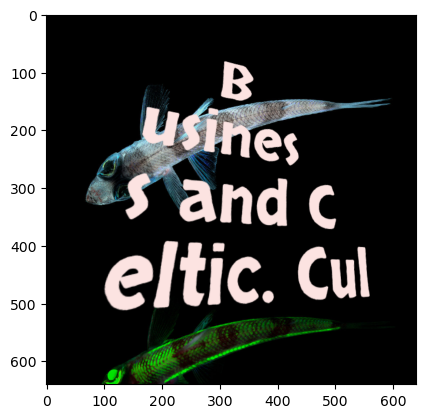

In [8]:
image, lines = next(image_generators[1])
text = koc.data_generation.convert_lines_to_paragraph(lines)
print('The first image in the validation set contains: ', text)
plt.imshow(image)

### Building base detector and recognizer models

In [9]:
detector = koc.detection.Detector(weights = 'clovaai_general')
recognizer = koc.recognition.Recognizer(
            alphabet=alphabet, 
            weights = 'kurapan')

Looking for C:\Users\LENOVO\.keras-ocr\craft_mlt_25k.h5
Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\LENOVO\.keras-ocr\crnn_kurapan_notop.h5


In [10]:
recognizer.compile()
for layer in recognizer.backbone.layers:
    layer.trainable = False

In [11]:
detector_batch_size = 1
detector_basepath = os.path.join(data_dir, f'detector_{datetime.datetime.now().isoformat()}')
detection_train_generator, detection_val_generator, detection_test_generator = [
    detector.get_batch_generator(
    image_generator=image_generator, 
    batch_size=detector_batch_size
    ) for image_generator in image_generators
]

In [19]:
detector.model.fit(
    detection_train_generator, 
    steps_per_epoch=math.ceil(len(background_splits[0])/detector_batch_size), 
    epochs=1000, 
    workers=0, 
    callbacks = [
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(f'{detector_basepath}.csv'),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{detector_basepath}.h5')
    ],
    validation_data=detection_val_generator, 
    validation_steps=math.ceil(len(background_splits[1])/detector_batch_size),
    batch_size=detector_batch_size)

Epoch 1/1000


C:\Users\LENOVO\anaconda3\lib\site-packages\keras_ocr\tools.py:580: RuntimeWarning: invalid value encountered in float_scalars
  rotation = np.arctan((tl[0] - bl[0]) / (tl[1] - bl[1]))


 90/827 [==>...........................] - ETA: 1:44:34 - loss: 0.0115

KeyboardInterrupt: 

### Training the recognizer 

In [12]:
max_length = 10
recognition_image_generators = [
    koc.data_generation.convert_image_generator_to_recognizer_input(
        image_generator=image_generator, 
        max_string_length=min(recognizer.training_model.input_shape[1][1], max_length),
        target_width=recognizer.model.input_shape[2],
        target_height=recognizer.model.input_shape[1],
        margin=1
    ) for image_generator in image_generators
]

This image contains:  Ato


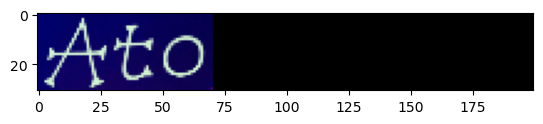

In [13]:
image, text = next(recognition_image_generators[1])
print('This image contains: ', text)
plt.imshow(image)